In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error # Equivalent to Brier Score in this scenario

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
os.chdir('march-machine-learning-mania-2025')
print(os.listdir())

['MNCAATourneyDetailedResults.csv', 'SampleSubmissionStage2.csv', 'WSecondaryTourneyTeams.csv', 'WNCAATourneySlots.csv', 'MNCAATourneyCompactResults.csv', 'MSeasons.csv', 'SampleSubmissionStage1.csv', 'WTeams.csv', 'elo_ratings_2025.csv', 'elo_submission_2025.csv', 'MRegularSeasonDetailedResults.csv', 'WNCAATourneyDetailedResults.csv', 'MNCAATourneySlots.csv', 'MGameCities.csv', 'MConferenceTourneyGames.csv', 'WNCAATourneyCompactResults.csv', 'WSecondaryTourneyCompactResults.csv', 'WSeasons.csv', 'Cities.csv', 'WRegularSeasonCompactResults.csv', 'WTeamSpellings.csv', 'WRegularSeasonDetailedResults.csv', 'MRegularSeasonCompactResults.csv', 'WNCAATourneySeeds.csv', 'MNCAATourneySeedRoundSlots.csv', 'elo_pre_tournament_ratings.csv', 'WConferenceTourneyGames.csv', 'WTeamConferences.csv', 'MTeamConferences.csv', 'elo_ratings_history.csv', 'MTeamCoaches.csv', 'MMasseyOrdinals.csv', 'Conferences.csv', 'MTeams.csv', 'WGameCities.csv', 'MNCAATourneySeeds.csv', 'MSecondaryTourneyTeams.csv', 'MTe

In [3]:
# Load Data
tourney_results = pd.concat([
    pd.read_csv("MNCAATourneyCompactResults.csv"),
    pd.read_csv("WNCAATourneyCompactResults.csv"),
], ignore_index=True) \
    .assign(League = lambda x: np.where(x['WTeamID'] < 3000, 1, 0))

regular_results = pd.concat([
    pd.read_csv("MRegularSeasonCompactResults.csv"),
    pd.read_csv("WRegularSeasonCompactResults.csv"),
], ignore_index=True) \
    .assign(League = lambda x: np.where(x['WTeamID'] < 3000, 1, 0))

teams_df = pd.concat([
    pd.read_csv('MTeams.csv'),
    pd.read_csv('WTeams.csv') \
        .assign(TeamName = lambda x: x['TeamName'] + " - Womens"),
], ignore_index=True) \
    .assign(League = lambda x: np.where(x['TeamID'] < 3000, 1, 0))

display(tourney_results.head())
display(regular_results.head())
display(teams_df)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,League
0,1985,136,1116,63,1234,54,N,0,1
1,1985,136,1120,59,1345,58,N,0,1
2,1985,136,1207,68,1250,43,N,0,1
3,1985,136,1229,58,1425,55,N,0,1
4,1985,136,1242,49,1325,38,N,0,1


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,League
0,1985,20,1228,81,1328,64,N,0,1
1,1985,25,1106,77,1354,70,H,0,1
2,1985,25,1112,63,1223,56,H,0,1
3,1985,25,1165,70,1432,54,H,0,1
4,1985,25,1192,86,1447,74,H,0,1


,TeamID,TeamName,FirstD1Season,LastD1Season,League
0,1101,Abilene Chr,2014.0,2025.0,1
1,1102,Air Force,1985.0,2025.0,1
2,1103,Akron,1985.0,2025.0,1
3,1104,Alabama,1985.0,2025.0,1
4,1105,Alabama A&M,2000.0,2025.0,1
...,...,...,...,...,...
753,3476,Stonehill - Womens,NaN,NaN,0
754,3477,East Texas A&M - Womens,NaN,NaN,0
755,3478,Le Moyne - Womens,NaN,NaN,0
756,3479,Mercyhurst - Womens,NaN,NaN,0


In [4]:
# These utility functions are used to create a similar format to the final submission format.
def add_id(df):
    df['LowTeamID'] = df[['WTeamID', 'LTeamID']].min(axis=1) 
    df['HighTeamID'] = df[['WTeamID', 'LTeamID']].max(axis=1)
    df['ID'] = df['Season'].astype('str') + '_' + df['LowTeamID'].astype('str') + "_" + df['HighTeamID'].astype('str')
    df.drop(['LowTeamID', 'HighTeamID'], axis=1, inplace=True)
    return df

def id_to_teams(df):
    df['LowTeamID'] = df['ID'].str.split('_', expand=True)[1].astype('int')
    df['HighTeamID'] = df['ID'].str.split('_', expand=True)[2].astype('int')
    return df

def prep_tourney(df):
    df = df.copy()
    df = add_id(df)
    df = id_to_teams(df)
    df['Actual'] = np.where(df['WTeamID'] == df['LowTeamID'], 1, 0)
    return df[['ID', 'Season', 'LowTeamID', 'HighTeamID', 'Actual']]

prep_tourney(tourney_results).sample(20) # sampling to get a better look at the data

,ID,Season,LowTeamID,HighTeamID,Actual
2705,2000_3353_3397,2000,3353,3397,0
3358,2011_3257_3435,2011,3257,3435,1
2182,2018_1242_1437,2018,1242,1437,0
1126,2002_1228_1242,2002,1228,1242,0
702,1996_1280_1433,1996,1280,1433,1
3032,2006_3328_3337,2006,3328,3337,1
1909,2014_1173_1196,2014,1173,1196,0
2236,2019_1199_1211,2019,1199,1211,0
192,1988_1131_1181,1988,1131,1181,0
253,1989_1116_1258,1989,1116,1258,1


In [20]:
# Basic Elo
class Elo:
    def __init__(self, default_rating=1000, k=50, scale_factor=400): # these are my starting ratings
        self.default_rating = default_rating # this value
        self.k = k
        self.scale_factor = scale_factor
    
    def calc_prob(self, rating_a, rating_b):
        prob_a = 1 / (1 + 10 ** ((rating_b - rating_a) / self.scale_factor))
        prob_b = 1 - prob_a
        return prob_a, prob_b
    
    def update_ratings(self, rating_a, rating_b, outcome):
        prob_a, prob_b = self.calc_prob(rating_a, rating_b)
        rating_a_new = rating_a + self.k * (outcome - prob_a)
        rating_b_new = rating_b + self.k * ((1 - outcome) - prob_b)
        return rating_a_new, rating_b_new
    
    def calc_rating_history(self, df, teams_df):
        df = df.copy()
        # 'Date' is a psuedo date used to show progression within a season and year
        # without the long gaps. This is just one way of simplifying that.
        df['Date'] = df['DayNum'] + 154 * (df['Season'] - df['Season'].min()) 
        
        ids = pd.concat([df['WTeamID'], df['LTeamID']]).unique()
        team_ratings = dict.fromkeys(ids, self.default_rating)
        ratings_history = []
        
        for _, row in df.iterrows():
            team_a = row.WTeamID
            team_b = row.LTeamID
            date = row.Date
            
            a_new, b_new = self.update_ratings(team_ratings[team_a], team_ratings[team_b], outcome=1)
            team_ratings[team_a] = a_new
            team_ratings[team_b] = b_new
        
            ratings_history.append({'Season': row['Season'], 'DayNum': row['DayNum'], 'Date': date, 'TeamID': team_a, 'Rating': a_new})
            ratings_history.append({'Season': row['Season'], 'DayNum': row['DayNum'], 'Date': date, 'TeamID': team_b, 'Rating': b_new})
        
        r_history = pd.DataFrame(ratings_history)
        r_history = r_history.merge(teams_df[['TeamID', 'TeamName']], on='TeamID', how='left')
        r_history['GameType'] = np.where(r_history['DayNum'] <= 132, 'Regular', 'Tourney')
        return r_history
    
    def pre_tourney_ratings(self, r_history):
        return (r_history.loc[r_history['GameType'] == 'Regular']
                .sort_values(['Season', 'TeamID', 'Date'])
                .groupby(['Season', 'TeamID'], as_index=False)['Rating']
                .last())
    
    def add_elo(self, df, elo_df):
        df = df.merge(elo_df, how='left', left_on=['Season', 'LowTeamID'], right_on=['Season', 'TeamID'])
        df = df.merge(elo_df, how='left', left_on=['Season', 'HighTeamID'], right_on=['Season', 'TeamID'])
        df = df.drop(['TeamID_x', 'TeamID_y'], axis=1)
        df = df.rename(columns={'Rating_x': 'EloRating_x', 'Rating_y': 'EloRating_y'})
        df['EloPred'] = df.apply(lambda x: self.calc_prob(x['EloRating_x'], x['EloRating_y'])[0], axis=1)
        return df
    
    def eval_elo(self, games_df, teams_df, tourney_df):
        r_history = self.calc_rating_history(games_df, teams_df=teams_df)
        pre_tourney_df = self.pre_tourney_ratings(r_history)
        tourney_df = self.add_elo(tourney_df, pre_tourney_df)
        tourney_df['Brier'] = (tourney_df['Actual'] - tourney_df['EloPred']) ** 2
        return tourney_df
    
tourney_df = (
    prep_tourney(tourney_results)
)

e = Elo(k=65, scale_factor=558)
season_scores = e.eval_elo(games_df=regular_results, teams_df=teams_df, tourney_df=tourney_df).groupby('Season', as_index=False)['Brier'].mean()
print('Mean Brier: ', season_scores['Brier'].mean())
season_scores.query('Season > 2003')


Mean Brier:  0.17485429805930236


,Season,Brier
19,2004,0.173358
20,2005,0.163852
21,2006,0.174459
22,2007,0.161026
23,2008,0.140345
24,2009,0.154498
25,2010,0.169386
26,2011,0.184230
27,2012,0.145155
28,2013,0.182455


In [17]:
# Install first: pip install scikit-optimize
from skopt import gp_minimize
from skopt.space import Real, Integer

def evaluate_params(k, scale_factor, regular_results, tourney_results, teams_df):
    """Evaluate Elo model with given parameters"""
    e = Elo(k=k, scale_factor=scale_factor)
    tourney_df_processed = prep_tourney(tourney_results)
    result = e.eval_elo(games_df=regular_results, teams_df=teams_df, tourney_df=tourney_df_processed)
    # Only consider results after 2000 for evaluation
    return result[result['Season'] > 2000]['Brier'].mean()

def objective(params):
    k, scale_factor = params
    return evaluate_params(k, scale_factor, regular_results, tourney_results, teams_df)

# Define search space
space = [Integer(10, 80, name='k'),
         Integer(150, 800, name='scale_factor')]

# Perform Bayesian optimization
result = gp_minimize(objective, space, n_calls=30, random_state=42, verbose=True)

print(f"Best parameters: k={result.x[0]}, scale_factor={result.x[1]}")
print(f"Best Brier score: {result.fun:.5f}")

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.0849
Function value obtained: 0.1706
Current minimum: 0.1706
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 9.1811
Function value obtained: 0.1666
Current minimum: 0.1666
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 8.7300
Function value obtained: 0.1682
Current minimum: 0.1666
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 8.7649
Function value obtained: 0.1666
Current minimum: 0.1666
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 8.8482
Function value obtained: 0.1752
Current minimum: 0.1666
Iteration No: 6 started. Evaluating

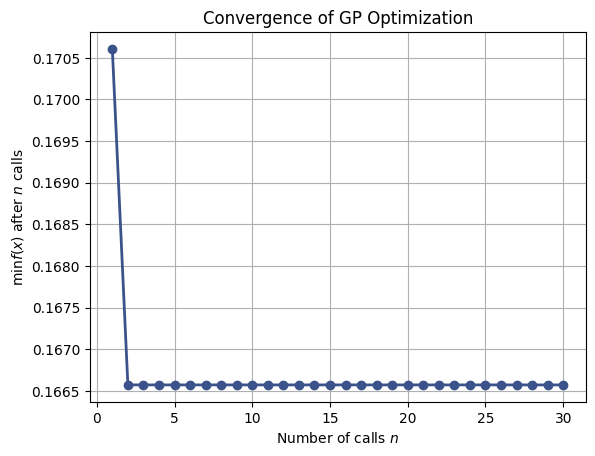

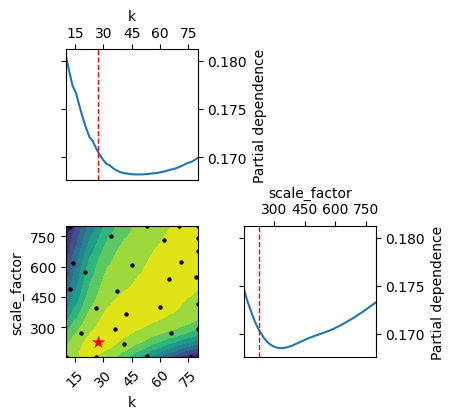

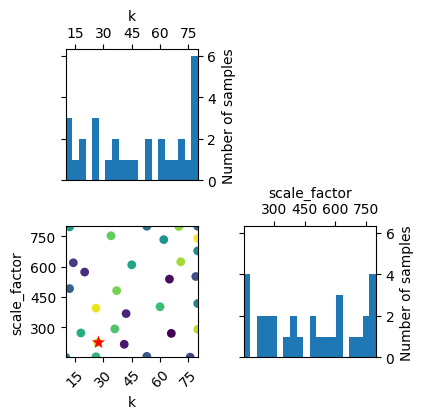

In [18]:
from skopt.plots import plot_convergence, plot_objective, plot_evaluations

# After running gp_minimize
# 1. Plot convergence over iterations
_ = plot_convergence(result)
plt.title('Convergence of GP Optimization')
plt.show()

# 2. Plot objective function and parameter relationships
_ = plot_objective(result)
plt.show()

# 3. Plot all evaluations
_ = plot_evaluations(result)
plt.show()

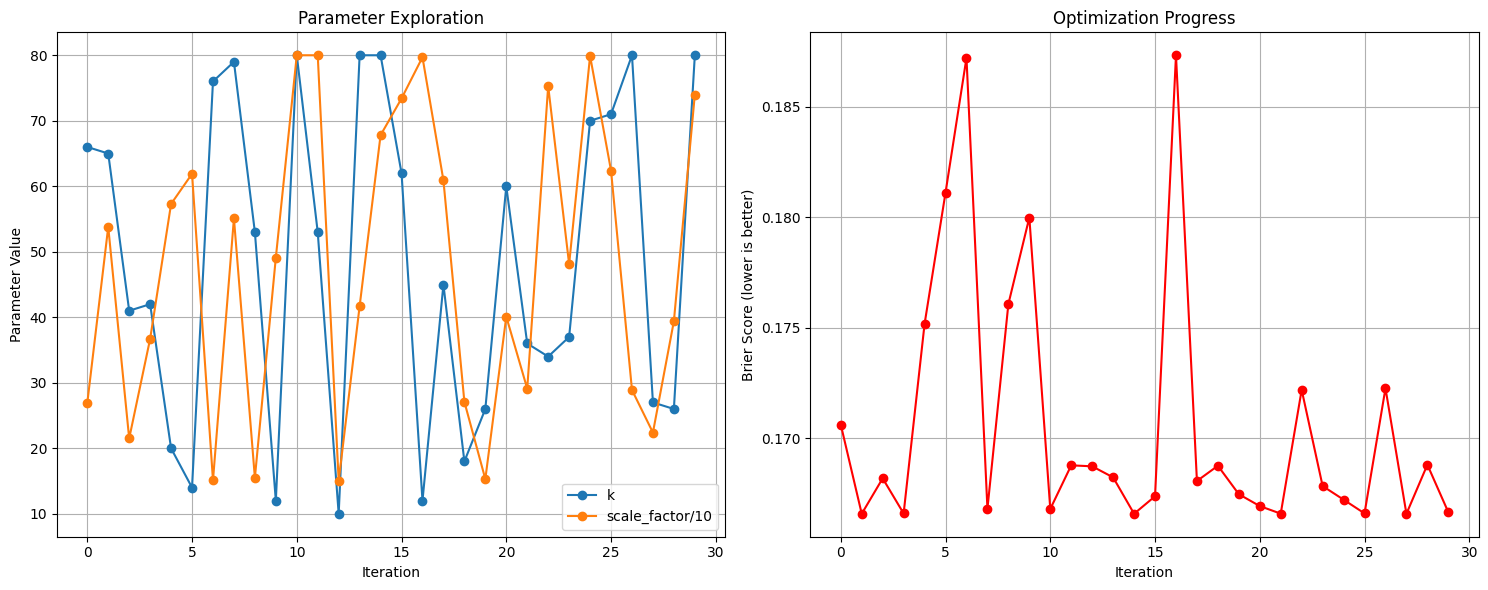

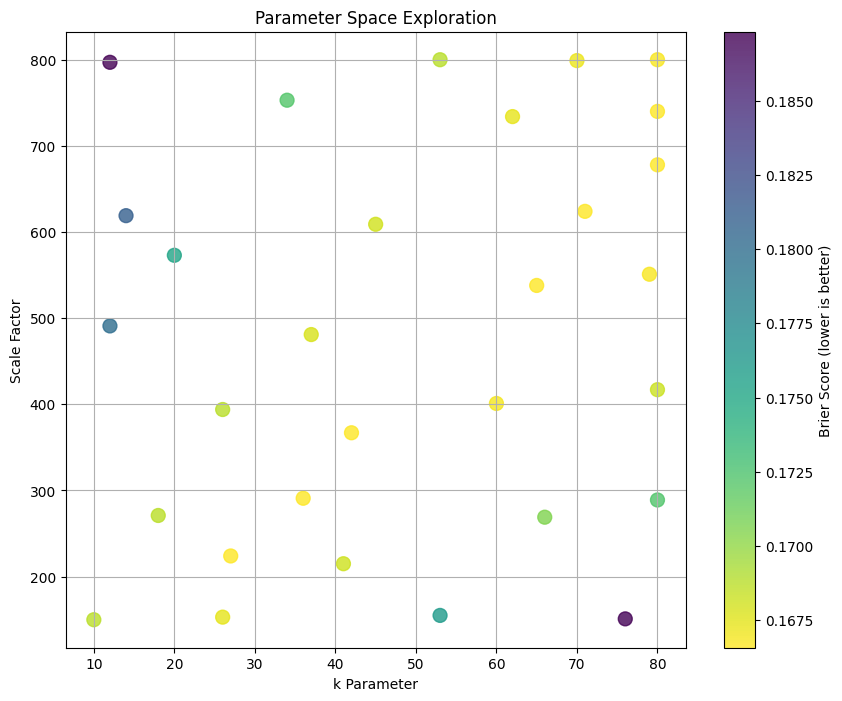

In [19]:
# Extract data from optimization result
params_df = pd.DataFrame({
    'iteration': range(len(result.func_vals)),
    'k': [x[0] for x in result.x_iters],
    'scale_factor': [x[1] for x in result.x_iters],
    'brier_score': result.func_vals
})

# Plot optimization progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Parameter values during optimization
ax1.plot(params_df['iteration'], params_df['k'], 'o-', label='k')
ax1.plot(params_df['iteration'], params_df['scale_factor']/10, 'o-', label='scale_factor/10')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Parameter Value')
ax1.legend()
ax1.set_title('Parameter Exploration')
ax1.grid(True)

# Brier score progression
ax2.plot(params_df['iteration'], params_df['brier_score'], 'o-', color='red')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Brier Score (lower is better)')
ax2.set_title('Optimization Progress')
ax2.grid(True)

plt.tight_layout()
plt.show()

# Create heatmap of results
plt.figure(figsize=(10, 8))
plt.scatter(
    params_df['k'], 
    params_df['scale_factor'], 
    c=params_df['brier_score'],
    cmap='viridis_r',  # reversed so darker = better
    s=100,
    alpha=0.8
)
plt.colorbar(label='Brier Score (lower is better)')
plt.xlabel('k Parameter')
plt.ylabel('Scale Factor')
plt.title('Parameter Space Exploration')
plt.grid(True)
plt.show()

In [23]:
# Create Elo model with optimized parameters
best_k, best_scale_factor = result.x
final_elo = Elo(k=best_k, scale_factor=best_scale_factor)

# Calculate full ratings history
ratings_history = final_elo.calc_rating_history(df=regular_results, teams_df=teams_df)

# Option 1: Export full ratings history
ratings_history.to_csv('elo_ratings_history.csv', index=False)
print("Full ratings history exported to 'elo_ratings_history.csv'")

# Option 2: Export only pre-tournament ratings (usually what you want for predictions)
pre_tourney = final_elo.pre_tourney_ratings(ratings_history)
pre_tourney.to_csv('elo_pre_tournament_ratings.csv', index=False)
print("Pre-tournament ratings exported to 'elo_pre_tournament_ratings.csv'")

# Option 3: Export final ratings for most recent season only (for 2025 predictions)
latest_season = pre_tourney['Season'].max()
latest_ratings = pre_tourney[pre_tourney['Season'] == latest_season]
latest_ratings.to_csv(f'elo_ratings_{latest_season}.csv', index=False)
print(f"Latest season ({latest_season}) ratings exported to 'elo_ratings_{latest_season}.csv'")

Full ratings history exported to 'elo_ratings_history.csv'
Pre-tournament ratings exported to 'elo_pre_tournament_ratings.csv'
Latest season (2025) ratings exported to 'elo_ratings_2025.csv'


In [2]:
# Load the latest pre-tournament ratings for 2025
latest_ratings = pd.read_csv('elo_ratings_2025.csv')

# Separate men's and women's teams based on ID
mens_teams = [team for team in latest_ratings['TeamID'].unique() if str(team).startswith('1')]
womens_teams = [team for team in latest_ratings['TeamID'].unique() if str(team).startswith('3')]

print(f"Found {len(mens_teams)} men's teams and {len(womens_teams)} women's teams")

# Generate matchups only between teams of the same gender
matchups = []

# Men's matchups
for i, team1 in enumerate(mens_teams):
    for team2 in mens_teams[i+1:]:
        low_id = min(team1, team2)
        high_id = max(team1, team2)
        matchup_id = f"2025_{low_id}_{high_id}"
        matchups.append(matchup_id)
        
# Women's matchups
for i, team1 in enumerate(womens_teams):
    for team2 in womens_teams[i+1:]:
        low_id = min(team1, team2)
        high_id = max(team1, team2)
        matchup_id = f"2025_{low_id}_{high_id}"
        matchups.append(matchup_id)

men_matchups = len(mens_teams) * (len(mens_teams)-1) // 2
women_matchups = len(womens_teams) * (len(womens_teams)-1) // 2
print(f"Generated {len(matchups)} possible matchups ({men_matchups} men's + {women_matchups} women's)")

# Create the submission dataframe
submission = pd.DataFrame({'ID': matchups})

# Create a dictionary of team ratings for quick lookup
team_ratings = dict(zip(latest_ratings['TeamID'], latest_ratings['Rating']))

# Function to calculate win probability using your optimized Elo parameters
def predict_matchup(row, ratings_dict, k=result.x[0], scale_factor=result.x[1]):
    # Extract TeamIDs from the ID string
    season, low_id, high_id = row['ID'].split('_')
    low_id, high_id = int(low_id), int(high_id)
    
    # Get Elo ratings for both teams
    rating_low = ratings_dict[low_id]
    rating_high = ratings_dict[high_id]
    
    # Calculate probability using Elo formula
    prob_low_wins = 1 / (1 + 10 ** ((rating_high - rating_low) / scale_factor))
    return prob_low_wins

# Calculate predictions for each matchup
submission['Pred'] = submission.apply(predict_matchup, axis=1, ratings_dict=team_ratings)

# Save the submission file
submission.to_csv('elo_submission_2025.csv', index=False)

print(f"Submission file created with {len(submission)} predictions.")
print("First few predictions:")
print(submission.head())

Found 364 men's teams and 362 women's teams
Generated 131407 possible matchups (66066 men's + 65341 women's)


NameError: name 'result' is not defined

In [5]:
import random
import pandas as pd
import time
import re

def load_data():
    try:
        # Load ratings file
        ratings = pd.read_csv('elo_ratings_2025.csv')
        
        # Load team name files
        men_teams = pd.read_csv('MTeams.csv')
        women_teams = pd.read_csv('WTeams.csv')
        
        # Add women's suffix to match your data format
        women_teams['TeamName'] = women_teams['TeamName'] + " - Womens"
        
        # Combine team data
        teams = pd.concat([men_teams, women_teams], ignore_index=True)
        
        # Load submission file with probabilities
        submission = pd.read_csv('elo_submission_2025.csv')
        
        # Create dictionary for quick lookup
        submission_dict = {}
        for _, row in submission.iterrows():
            submission_dict[row['ID']] = row['Pred']
        
        # Create dictionaries for team lookups
        team_name_to_id = dict(zip(teams['TeamName'].str.lower(), teams['TeamID']))
        team_id_to_name = dict(zip(teams['TeamID'], teams['TeamName']))
            
        return team_name_to_id, team_id_to_name, submission_dict
            
    except Exception as e:
        print(f"Error loading data: {e}")
        print("Make sure MTeams.csv and WTeams.csv are available in your data folder.")
        return {}, {}, {}

# Load the data
team_name_to_id, team_id_to_name, submission_dict = load_data()

def find_team_id(team_input):
    """Try to match team input to a team ID"""
    # Try direct lookup first
    if team_input.lower() in team_name_to_id:
        return team_name_to_id[team_input.lower()]
    
    # Try partial match
    matches = [name for name in team_name_to_id.keys() if team_input.lower() in name]
    if len(matches) == 1:
        return team_name_to_id[matches[0]]
    elif len(matches) > 1:
        print(f"Multiple matches found: {', '.join([name for name in matches])}")
        return None
    
    # Try ID
    if team_input.isdigit():
        team_id = int(team_input)
        if team_id in team_id_to_name:
            return team_id
    
    # Not found
    return None

def predict_score(win_probability, avg_total_points=140):
    """Convert win probability to predicted score"""
    # Convert probability to log-odds, then to point differential
    # Research suggests ~3.5 point spread per 100 Elo points
    # With scale_factor around 224-558, this gives reasonable spreads
    import math
    if win_probability == 0.5:
        point_spread = 0
    else:
        point_spread = 15 * math.log(win_probability / (1 - win_probability))
    
    # Calculate team scores based on point spread and average total
    team1_score = avg_total_points/2 + point_spread/2
    team2_score = avg_total_points/2 - point_spread/2
    
    # Round to nearest whole number
    team1_score = int(round(team1_score))
    team2_score = int(round(team2_score))
    
    return team1_score, team2_score

def predict_winner():
    print("\n🏀 MARCH MADNESS MATCHUP PREDICTOR 🏀")
    print("Enter team name or ID (or 'q' to quit)")
    
    while True:
        # Get team inputs
        team1_input = input("\nEnter first team: ")
        if team1_input.lower() == 'q':
            break
        
        team1_id = find_team_id(team1_input)
        if team1_id is None:
            print(f"Could not find team: {team1_input}")
            continue
            
        team2_input = input("Enter second team: ")
        if team2_input.lower() == 'q':
            break
        
        team2_id = find_team_id(team2_input)
        if team2_id is None:
            print(f"Could not find team: {team2_input}")
            continue
        
        # Get team names for display
        team1_name = team_id_to_name[team1_id]
        team2_name = team_id_to_name[team2_id]
        
        print(f"\nMatchup: {team1_name} vs {team2_name}")
        print("Looking up Elo prediction...")
        
        # Create matchup ID in proper format (lower ID first)
        if team1_id < team2_id:
            matchup_id = f"2025_{team1_id}_{team2_id}"
            first_team_is_lower = True
        else:
            matchup_id = f"2025_{team2_id}_{team1_id}"
            first_team_is_lower = False
        
        # Add dramatic effect
        for _ in range(3):
            print(".", end="", flush=True)
            time.sleep(0.5)
        
        # Look up prediction from submission file
        if matchup_id in submission_dict:
            win_prob = submission_dict[matchup_id]
            
            # Adjust probability based on which team was entered first
            if not first_team_is_lower:
                win_prob = 1 - win_prob
                
            print(f"\n\nElo prediction: {win_prob:.4f}")

            # Predict the score
            team1_score, team2_score = predict_score(win_prob)
            print(f"Predicted score: {team1_name} {team1_score}, {team2_name} {team2_score}")
            
            # Generate random outcome to simulate game
            random_outcome = random.random()
            print(f"Random outcome: {random_outcome:.4f}")
            
            # Determine winner based on prediction
            if random_outcome < win_prob:
                print(f"🏆 {team1_name} wins with {int(win_prob*100)}% probability! 🏆")
            else:
                print(f"🏆 {team2_name} wins with {int((1-win_prob)*100)}% probability! 🏆")
        else:
            print(f"\nNo prediction found for this matchup: {matchup_id}")
        
        print("\n" + "-"*50)

# Run the predictor
predict_winner()


🏀 MARCH MADNESS MATCHUP PREDICTOR 🏀
Enter team name or ID (or 'q' to quit)

Matchup: Marquette vs New Mexico
Looking up Elo prediction...
...

Elo prediction: 0.5812
Predicted score: Marquette 72, New Mexico 68
Random outcome: 0.7675
🏆 New Mexico wins with 41% probability! 🏆

--------------------------------------------------

Matchup: Michigan St vs Bryant
Looking up Elo prediction...
...

Elo prediction: 0.9637
Predicted score: Michigan St 95, Bryant 45
Random outcome: 0.0690
🏆 Michigan St wins with 96% probability! 🏆

--------------------------------------------------

Matchup: Auburn vs Creighton
Looking up Elo prediction...
...

Elo prediction: 0.6700
Predicted score: Auburn 75, Creighton 65
Random outcome: 0.4915
🏆 Auburn wins with 66% probability! 🏆

--------------------------------------------------

Matchup: Michigan vs Texas A&M
Looking up Elo prediction...
...

Elo prediction: 0.5709
Predicted score: Michigan 72, Texas A&M 68
Random outcome: 0.9716
🏆 Texas A&M wins with 42%